## **Importing libraries**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from pathlib import Path

2025-10-25 11:27:13.511563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 11:27:14.192259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 11:27:17.701690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Verifying the GPU Setup [tensorflow + CUDA (Compute Unified Device Architecture) => Let's you use GPU for Computation other than Graphics]

In [2]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

## **Data Preprocessing**
#### Used *'https://youtube.com/playlist?list=PLvz5lCwTgdXDNcXEVwwHsb9DwjNXZGsoy&si=gPCwVkKpS63FVLAC'* for guidance

# Training Image Preprocessing

In [3]:
curr_dir = os.getcwd()

In [4]:
training_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/train',
    labels="inferred", # leaving inferred, keras generates labels and class name automatically i.e.,
    # [Pepper_mold, Potato_healthy, Tomato_healthy, ...] alphabetically, where labels [0, 1, 2, ...]
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 24652 files belonging to 15 classes.


I0000 00:00:1761370943.328830   28044 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# normalizing training set
normalization_layer = layers.Rescaling(1./255.0)
training_set = training_set.map(lambda x, y: (normalization_layer(x), y))

## Validation Image Preprocessing

In [6]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 5278 files belonging to 15 classes.


In [7]:
# normalizing validation set
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))

In [8]:
for x, y in training_set:
    print(x, x.shape)
    print(y, y.shape)
    break

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

# **Building Model**

In [9]:
cnn = Sequential()

## Building Convolution Layers (Architecture)

In [10]:
# 🧠 CNN Concept Summary:

# 1️⃣ Each cnn.add() = one layer (Conv, Pool, etc.)
#     → Conv2D = learns features (edges → textures → shapes)
#     → MaxPool2D = downsamples feature maps (keeps strongest features)

# 2️⃣ Repeated Conv+Pool blocks = deeper understanding:
#     Block1: basic edges/colors
#     Block2: shapes/textures
#     Block3: complex leaf patterns
#     Block4: disease regions

# 3️⃣ Kernel (3x3): small filter sliding over input
#     → detects local patterns (like edge fragments)

# 4️⃣ padding='same': adds zero borders → output height & width stay same
#     padding='valid': no padding → output shrinks

# 5️⃣ input_shape: only needed in the first Conv2D layer
#     → later layers infer input size automatically

# 6️⃣ Max Pooling (2x2): reduces feature map size by half
#     → keeps key activations, adds translation invariance

# 7️⃣ Hierarchy summary:
#     Input → Conv → Pool → Conv → Pool → Flatten → Dense → Output


In [11]:
cnn.add(Conv2D(filters=32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = [128,128, 3])) # input_size = [widht, height, input shape]
cnn.add(Conv2D(filters=32, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2)) # pool size -> shape of pooling filter, strides -> movement of sliding window

/home/root123/GitHub/Two_Months_ML_Journey/Week 4/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
cnn.add(Conv2D(filters=64, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(Conv2D(filters=64, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [13]:
cnn.add(Conv2D(filters=128, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(Conv2D(filters=128, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [14]:
# cnn.add(Conv2D(filters=256, kernel_size = 3, padding = 'same', activation = 'relu'))
# cnn.add(Conv2D(filters=256, kernel_size = 3, padding = 'same', activation = 'relu'))
# cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [15]:
# Flattening the results to pass to the dense layer
cnn.add(Flatten())

In [16]:
cnn.add(Dense(units = 64, activation = 'relu'))

In [17]:
# output layer
cnn.add(Dense(units = 15, activation = 'softmax'))

## Compiling Model

In [18]:
cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', Precision(), Recall()])

In [19]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,385,199 (9.10 MB)

 Trainable params: 2,385,199 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [20]:
training_history = cnn.fit(x = training_set, validation_data = validation_set, epochs = 20)

Epoch 1/20


2025-10-25 11:27:28.260658: I external/local_xla/xla/service/service.cc:163] XLA service 0x74c62c008e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-25 11:27:28.260709: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-10-25 11:27:28.406618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-25 11:27:28.725954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-25 11:27:28.776645: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-25 11:27:30.

  1/771 ━━━━━━━━━━━━━━━━━━━━ 2:44:41 13s/step - accuracy: 0.0312 - loss: 2.7128 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1761370959.190246   28166 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


769/771 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5526 - loss: 1.5152 - precision: 0.8128 - recall: 0.3920

2025-10-25 11:28:24.341573: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv (f32[12,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-10-25 11:28:24.345401: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 3.505653573s
Trying algorithm eng13{} for conv (f32[12,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

771/771 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5528 - loss: 1.5141 - precision: 0.8129 - recall: 0.3924

2025-10-25 11:28:37.425302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_178', 4 bytes spill stores, 4 bytes spill loads

2025-10-25 11:28:37.474244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_178', 8 bytes spill stores, 8 bytes spill loads



771/771 ━━━━━━━━━━━━━━━━━━━━ 73s 78ms/step - accuracy: 0.6565 - loss: 1.1134 - precision: 0.8480 - recall: 0.5371 - val_accuracy: 0.7878 - val_loss: 0.6486 - val_precision: 0.8656 - val_recall: 0.7078
Epoch 2/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.8448 - loss: 0.4707 - precision: 0.8951 - recall: 0.8022 - val_accuracy: 0.8856 - val_loss: 0.3480 - val_precision: 0.9168 - val_recall: 0.8585
Epoch 3/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.8977 - loss: 0.3027 - precision: 0.9231 - recall: 0.8761 - val_accuracy: 0.8958 - val_loss: 0.3370 - val_precision: 0.9111 - val_recall: 0.8820
Epoch 4/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.9312 - loss: 0.2016 - precision: 0.9437 - recall: 0.9215 - val_accuracy: 0.8924 - val_loss: 0.3357 - val_precision: 0.9065 - val_recall: 0.8854
Epoch 5/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9521 - loss: 0.1394 - precision: 0.9591 - recall: 0.9463 - val_accuracy: 0.9189 - val_loss: 0.2

## Model Evaluation

In [21]:
train_loss, train_acc, train_pre, train_rec = cnn.evaluate(training_set)

771/771 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9978 - loss: 0.0071 - precision: 0.9978 - recall: 0.9978


In [22]:
print(train_loss, train_acc, train_pre, train_rec)

0.007066245656460524 0.9977689385414124 0.9978498816490173 0.9977689385414124


In [23]:
valid_loss, valid_acc, valid_pre, valid_rec = cnn.evaluate(validation_set)

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9380 - loss: 0.3231 - precision: 0.9401 - recall: 0.9373


In [24]:
print(valid_loss, valid_acc, valid_pre, valid_rec)

0.3231140673160553 0.9380447268486023 0.9401368498802185 0.9372868537902832


## Accuracy Visualization

In [25]:
print(training_history.history['accuracy'])

[0.6564579010009766, 0.8448401689529419, 0.8976553678512573, 0.9312428832054138, 0.9520931243896484, 0.9637352228164673, 0.9704283475875854, 0.973227322101593, 0.9792308807373047, 0.9819081425666809, 0.981705367565155, 0.9843826293945312, 0.9852344393730164, 0.9862485527992249, 0.9877089262008667, 0.9876683354377747, 0.9855995178222656, 0.9903455972671509, 0.9903455972671509, 0.9875872135162354]


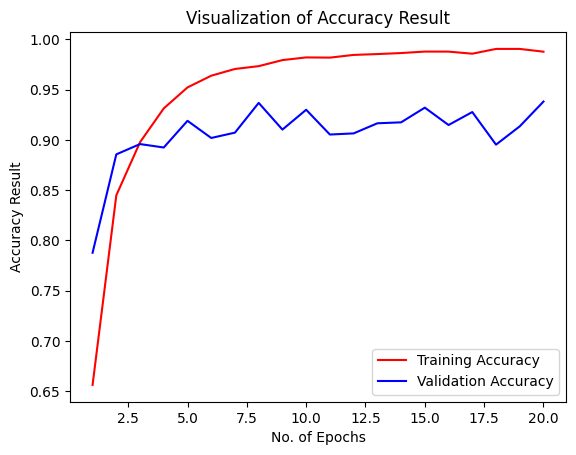

In [26]:
epochs = [i for i in range(1,21)]
plt.plot(epochs, training_history.history['accuracy'], color='red', label ='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label ='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Result')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

## Saving Model

In [27]:
cnn.save(f'{curr_dir}/saved_models/cnn_scratch_model.keras') # one extension of saving, not using h5 as keras takes less space

In [28]:
training_history.history

{'accuracy': [0.6564579010009766,
  0.8448401689529419,
  0.8976553678512573,
  0.9312428832054138,
  0.9520931243896484,
  0.9637352228164673,
  0.9704283475875854,
  0.973227322101593,
  0.9792308807373047,
  0.9819081425666809,
  0.981705367565155,
  0.9843826293945312,
  0.9852344393730164,
  0.9862485527992249,
  0.9877089262008667,
  0.9876683354377747,
  0.9855995178222656,
  0.9903455972671509,
  0.9903455972671509,
  0.9875872135162354],
 'loss': [1.11342191696167,
  0.4707005023956299,
  0.30273914337158203,
  0.20163024961948395,
  0.1394302397966385,
  0.10478397458791733,
  0.08686921000480652,
  0.07729388773441315,
  0.06438928842544556,
  0.052116408944129944,
  0.05750173702836037,
  0.04915724694728851,
  0.04672279208898544,
  0.04206666350364685,
  0.035654425621032715,
  0.03499694913625717,
  0.043262213468551636,
  0.03157257288694382,
  0.03084174543619156,
  0.038344427943229675],
 'precision': [0.8479666709899902,
  0.8950893878936768,
  0.9231098294258118,
  

In [29]:
# storing history in json format
import json
with open(f'{curr_dir}/training_history/cnn_scratch_training_hist.json', 'w') as f:
  json.dump(training_history.history, f)